In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Description: A script to produce high-resolution ocean topography maps using the BFN-QG data assimilation method (F. Le Guillou).
This algorithm takes care of downloading the input observations, pre-processing the boundary ∏, plotting the data to be used,
performing the assimilation using MASSH, processing results, making various diagnostics on the output, and sending the maps 
and results to an external FTP server. It can be used both for near-real-time and reanalysis applications.

Author: adrienstella
Date: 2023-07-19
"""

import os
from datetime import timedelta
import sys

### Parameters to adjust

In [2]:
destination = None # Available options: 'ifremer'
make_lagrangian_diags = False # True or False
draw_L3 = False # True or False
make_alongtrack_rmse = False # True or False
make_duacs_comp = 'today' # Available options: 'today', 'YYYY-MM-DD' (choose a date), 'interactive', 'none'

output_maps_interval = 6 # final averaging of ssh, in hours - default = 24

dir_massh = '../MASSH/mapping'
path_config = './NRT_BFN_main_config.py' 

###  0. INITIALIZATION

name_experiment: NRT_BFN_GPGP_test
saveoutputs: True
name_exp_save: NRT_BFN_GPGP_test
path_save: ./output_NRT_BFN_GPGP_test/20240219/
tmp_DA_path: ./scratch/NRT_BFN_GPGP_test
init_date: 2024-02-11 00:00:00
final_date: 2024-02-19 00:00:00
assimilation_time_step: 3:00:00
saveoutput_time_step: 3:00:00
flag_plot: 1
write_obs: False
path_obs: ./scratch/NRT_BFN_GPGP_test
name_lon: lon
name_lat: lat
name_time: time
plot_time_step: 1 day, 0:00:00
time_obs_min: None
time_obs_max: None
compute_obs: False

NAME_OBSOP is not set in the configuration file
NAME_BASIS is not set in the configuration file
NAME_DIAG is not set in the configuration file


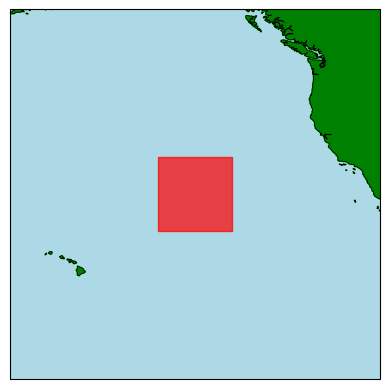

In [3]:
sys.path.append(dir_massh)
currdir=os.getcwd()

from src import exp
config = exp.Exp(path_config)
name_experiment = config.EXP.name_experiment
today = config.EXP.final_date
numdays = int((today-config.EXP.init_date)/timedelta(days = 1))

lon_min = config.GRID.lon_min                            
lon_max = config.GRID.lon_max                               
lat_min = config.GRID.lat_min                                 
lat_max = config.GRID.lat_max
bbox = [lon_min, lon_max, lat_min, lat_max]   

from tools.plot_tools import where_is_this
where_is_this(bbox, 20) 

###  1. DATA DOWNLOAD

In [4]:
from tools.ftp_transfer import download_nadirs_cmems, download_swot_nadir
from tools.processing import make_mdt

# What datasets to download
datasets = [
    'dataset-duacs-nrt-global-al-phy-l3', 
    'dataset-duacs-nrt-global-c2n-phy-l3', 
    'dataset-duacs-nrt-global-h2b-phy-l3',
    'dataset-duacs-nrt-global-s3a-phy-l3',
    'dataset-duacs-nrt-global-s3b-phy-l3',
    'cmems_obs-sl_glo_phy-ssh_nrt_j3n-l3-duacs_PT1S',
    'cmems_obs-sl_glo_phy-ssh_nrt_s6a-hr-l3-duacs_PT1S',
]

dataset_l4 = 'dataset-duacs-nrt-global-merged-allsat-phy-l4'

# FTP connection to CMEMS server and observational data download
download_nadirs_cmems(name_experiment, currdir, today, numdays, datasets, dataset_l4)
download_swot_nadir(name_experiment, currdir, today)

Retreiving data for nrt_global_al_phy_l3_20240201_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240202_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240203_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240204_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240205_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240206_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240207_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240208_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240209_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240210_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240211_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240212_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240213_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240214_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240215_20240219.nc
Retreiving data for nrt_global_al_phy_l3_20240216_20240219.nc
Retreivi

error_perm: 550 /data/Data/ALTI/DUACS_SWOT_Nadir/L3_Along_track: No such file or directory

In [10]:
# If needed, download and properly formats mdt file
make_mdt(name_experiment, currdir,bbox)

NameError: name 'secretcodes' is not defined

### 2. BOUNDARY CONDITIONS

In [ ]:
from tools.processing import compute_filled_map

# Rework DUACS dataset for optimal boundary conditions : extrapolate data to fill coasts. 
# Then a mask is used in MASSH to select only ocean and avoid awkward 0 values around coasts
BC_data_path = currdir+'/input_'+name_experiment+'/'+today.strftime('%Y%m%d')+'/dataset-duacs-nrt-global-merged-allsat-phy-l4/*.nc'
save_new_BC_to = currdir+'/input_'+name_experiment+'/'+today.strftime('%Y%m%d')+'/duacs_l4_filled.nc'

compute_filled_map(BC_data_path, save_new_BC_to, bbox)

### 3. DATA ASSIMILATION WITH MASSH (BFN-QG)

In [ ]:
# State
from src import state as state
State = state.State(config)

# Obs
from src import obs as obs # if no files to open, re-download data
dict_obs = obs.Obs(config,State)

In [ ]:
if draw_L3 == True:
    from tools.plot_tools import plot_l3_data

    #FIXME: This fails if one of the datasets asked for is empty. Check in inputs that all satellites here actually have data.
    l3_datasets = [
        'obs*ALG',
        'obs*C2N',
        'obs*H2B',
        'obs*S3A',
        'obs*S3B',
        'obs*SWOTN',
        'obs*'
    ]
    plot_l3_data(bbox, l3_datasets, today, numdays, name_experiment)

In [ ]:
# Model
from src import mod as mod
Model = mod.Model(config,State)

# Bondary Conditions
from src import bc as bc
Bc = bc.Bc(config)

# Inversion
from src import inv as inv
inv.Inv(config,State,Model,dict_obs=dict_obs,Bc=Bc)

### 4. RESULTS PROCESSING

In [ ]:
from tools.processing import nc_processing
nc_processing(name_experiment, today=today, numdays=9, frequency_hours = output_maps_interval)

### 5. DIAGNOSTICS

#### 5.1 DUACS comparison

In [ ]:
from tools.plot_tools import plot_duacs_comp
plot_duacs_comp(config.EXP.init_date, name_experiment, today, bbox, make_duacs_comp)

#### 5.2 Alongtrack observations comparison

In [ ]:
if make_alongtrack_rmse == True:
    from tools.plot_tools import plot_alongtrack_rmse, plot_25_random_tracks
    plot_25_random_tracks('./scratch/'+name_experiment+'/', name_experiment, today.strftime('%Y%m%d'))
    plot_alongtrack_rmse('./scratch/'+name_experiment+'/', name_experiment, today.strftime('%Y%m%d'))

#### 5.3 LAMTA Lagrangian diagnostics

In [ ]:
if make_lagrangian_diags == True:
    dir_lamta = '/bettik/PROJECTS/pr-data-ocean/stellaa/lamtaLR'
    from tools.processing import apply_lamta
    lamta_diags_results = apply_lamta(name_experiment, currdir, dir_lamta, today, bbox, numdays=30, bathylvl =-3000)

### 6. MAPS UPLOAD

In [ ]:
# Here, make your own functions to send to somewhere else for NRT purposes. 
if destination == 'ifremer':
    from tools.ftp_transfer import ftp_to_ifremer
    ftp_to_ifremer(name_experiment, today, currdir)